# Book stock project

In this project we...


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
import seaborn as sns
from time import sleep
from tqdm import tqdm

## Data

In [ ]:

books = pd.read_csv('./data/books.csv')

books.head()


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [3]:
# Check data types
books.dtypes

book_id                        int64
goodreads_book_id              int64
best_book_id                   int64
work_id                        int64
books_count                    int64
isbn                          object
isbn13                       float64
authors                       object
original_publication_year    float64
original_title                object
title                         object
language_code                 object
average_rating               float64
ratings_count                  int64
work_ratings_count             int64
work_text_reviews_count        int64
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
image_url                     object
small_image_url               object
dtype: object

### Data scraping

Using each book id, we scrape the most popular reviews from goodreads.com


In [ ]:
# check if file exists
if os.path.exists('./data/most_popular_reviews.csv'):
    # load file skips first 5 lines of metadata and last 1 line of footer
    most_popular_reviews = pd.read_csv('./data/most_popular_reviews.csv', skiprows=5, skipfooter=1)
else:
    #run scraping scripts
    books = pd.read_csv('./data/books.csv')

    most_popular_reviews = pd.DataFrame(columns=["book_id", "score","date","review_text"])

    for index, row in tqdm(books.iterrows(), total=books.shape[0]):
        sleep(1)  # sleep for 1 second to avoid rate limiting
        book_id = row['book_id']
        url = f'https://www.goodreads.com/book/show/{book_id}'
        
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            # fetch elements with class "ReviewCard"
            review_cards = soup.find_all(class_='ReviewCard')
            for review in review_cards:
                try:
                    #seperate review text from class "ReviewText"
                    review_text = review.find(class_='ReviewText')
                    review_text = review_text.get_text(strip=True)
                    #clean review text by removing newline characters and line separators
                    review_text = review_text.replace('\n', ' ').replace('\r', ' ')

                    #fetch date from class "Text Text__body3"
            
                    date_elem = review.find(class_='Text Text__body3')
                    date = date_elem.get_text(strip=True).lower().replace(',', '')
                    month, day, year = date.split(' ')
                    # Get review score from class "RatingStars RatingStars__small"
                    # take the aria-label attribute, which is a string formmated as "Rating x out of 5"
                    rating_stars = review.find(class_='RatingStars RatingStars__small')
                    rating = rating_stars['aria-label']
                    rating = rating.split(' ')[1]  # extract the number part

                    most_popular_reviews.loc[len(most_popular_reviews)] ={
                        "book_id": book_id,
                        "score": rating,
                        "date": f"{month}/{day}/{year}",
                        "review_text": review_text
                    }
                except Exception as e:
                    print("Error parsing review:", e)
        if index % 100 == 0:
            #save progress every 100 books, just in case of interruption
            most_popular_reviews.to_csv('./data/most_popular_reviews'+str(index)+'.csv', index=False)
    #save final dataframe
    most_popular_reviews.to_csv('./data/most_popular_reviews.csv', index=False)
most_popular_reviews.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34996\2502378815.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  most_popular_reviews = pd.read_csv('./data/most_popular_reviews.csv', skiprows=5, skipfooter=1)


,book_id,score,date,review_text
0,1,5,july/22/2024,(A) 86%| ExtraordinaryNotes:A relationshippy r...
1,1,5,march/13/2022,(A) 86%| ExtraordinaryNotes:It dwells on the d...
2,1,5,may/26/2015,i dont want to talk to anyonedont even look at...
3,1,5,february/20/2023,"2023: Jak co reread, to mój ulubieniec.2021: W..."
4,1,5,january/10/2021,"""5. Should you feel that a family member, coll..."


In [21]:
print(most_popular_reviews.dtypes)
#convert data column to datetime
most_popular_reviews['date'] = pd.to_datetime(most_popular_reviews['date'])
print(most_popular_reviews.dtypes)

book_id                 int64
score                   int64
date           datetime64[ns]
review_text            object
dtype: object
book_id                 int64
score                   int64
date           datetime64[ns]
review_text            object
dtype: object


In [20]:
most_popular_reviews

,book_id,score,date,review_text
0,1,5,2024-07-22,(A) 86%| ExtraordinaryNotes:A relationshippy r...
1,1,5,2022-03-13,(A) 86%| ExtraordinaryNotes:It dwells on the d...
2,1,5,2015-05-26,i dont want to talk to anyonedont even look at...
3,1,5,2023-02-20,"2023: Jak co reread, to mój ulubieniec.2021: W..."
4,1,5,2021-01-10,"""5. Should you feel that a family member, coll..."
...,...,...,...,...
159831,9900,5,2013-10-10,Great book. This is a 'what if' book. It is a ...
159832,9900,4,2017-08-16,ჯიბრანის ფანტაზიით აღდგენილი 77 ადამიანის მონა...
159833,9900,5,2017-12-27,لقد احبني عيسى وما عرفت لذلك سبباولقد احببته ل...
159834,9900,5,2014-01-29,I don't know how many times I've read this boo...


In [22]:
def recency_score(date, current_date):
    days_since_review = (current_date - date).days
    if days_since_review <= 30:
        return 5
    elif days_since_review <= 90:
        return 4
    elif days_since_review <= 180:
        return 3
    elif days_since_review <= 365:
        return 2
    else:
        return 1
current_date = pd.to_datetime('2025-12-06')

most_popular_reviews['recency_score'] = most_popular_reviews['date'].apply(lambda x: recency_score(x, current_date))



In [23]:
# average recency score per book and merge with books dataframe
recency_scores = most_popular_reviews.groupby('book_id')['recency_score'].mean().reset_index()
recency_scores.rename(columns={'recency_score': 'avg_recency_score'}, inplace=True)
books = books.merge(recency_scores, on='book_id', how='left')

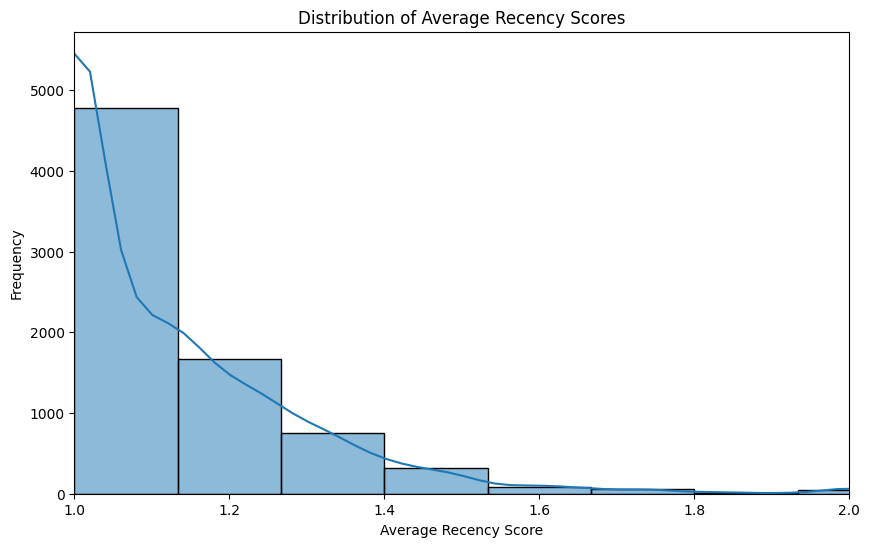

In [31]:
# plot distribution of recency scores, only show score between 1 and 2
plt.figure(figsize=(10,6))
sns.histplot(books['avg_recency_score'].dropna(), bins=30, kde=True)
# limit x axis to 1 to 2
plt.xlim(1, 2)
plt.title('Distribution of Average Recency Scores')
plt.xlabel('Average Recency Score')
plt.ylabel('Frequency')
plt.show()